In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import os

In [5]:
class wifimodel():
    def __init__(self, location):
        self.train_dir = f'../../data/{location}/train/'
        self.test_dir = f'../../data/{location}/testH/'
        self.model_df = pd.DataFrame()
        self.test_df = pd.DataFrame()

        self.fil_model_df = pd.DataFrame()
        self.fil_test_df = pd.DataFrame()

        self.SSID_list = []
        
        self.test_x_list = []
        self.test_y_list = []
        
        self.maxarea = 0
        self.maxarea2 = 0
        self.refwifi = []

        self.rssi_thres = 0
        self.range_num = 0
        self.range_num2 = 0

        file_list = os.listdir(self.train_dir)
        for file in file_list:
            df = pd.read_csv(self.train_dir + file,
                             sep="\t", engine='python', encoding="UTF-8", header=None)
            df = pd.DataFrame(
                {"cnt": list(df.iloc[:, 0]), "x": list(df.iloc[:, 1]), "y": list(df.iloc[:, 2]),
                 "ADDR": list(df.iloc[:, 3]),
                 "SSID": list(df.iloc[:, 4]),
                 "RSSI": list(df.iloc[:, 5])})
            self.model_df = pd.concat([self.model_df, df])

        file_list = os.listdir(self.test_dir)
        for file in file_list:
            df = pd.read_csv(self.test_dir + file,
                             sep="\t", engine='python', encoding="UTF-8", header=None)
            df = pd.DataFrame(
                {"cnt": list(df.iloc[:, 0]), "x": list(df.iloc[:, 1]), "y": list(df.iloc[:, 2]),
                 "ADDR": list(df.iloc[:, 3]),
                 "SSID": list(df.iloc[:, 4]),
                 "RSSI": list(df.iloc[:, 5])})
            self.test_df = pd.concat([self.test_df, df])
        
        self.mag_df = pd.read_csv(f'../mag/{location}/magx.txt', sep="\t", engine='python', encoding="cp949", header=None)

        self.ref_mag_df = copy.deepcopy(self.mag_df)
        
        for i in range(self.mag_df.shape[0]):
            for j in range(self.mag_df.shape[1]):
                if ((i % 6 == 0 ) and (j % 6 == 0) and (self.mag_df.iloc[i, j] != 0.0)):
                    self.maxarea += 1
        
        self.maxarea2 = sum(self.ref_mag_df[self.ref_mag_df != 0.0].count())
        self.mag_df[self.mag_df != 0.0] = np.nan

        self.maxX = self.mag_df.shape[0]
        self.maxY = self.mag_df.shape[1]

    def cal_area(self, posx, posy):
        cnt = 0
        temp = self.ref_mag_df.iloc[int(min(posx)): int(max(posx)), int(min(posy)): int(max(posy))]
        return sum(temp[temp != 0.0].count())
    
    def cal_area2(self, posx, posy):
        cnt = 0
        for i in range(len(posx)):
            if self.mag_df.iloc[posx[i], posy[i]] != 0.0:
                cnt += 1
        return cnt
    
    def define_range(self, range_num, inv_range_num):
        self.range_num = range_num
        self.inverse_range_num = inv_range_num
    
    def create_refwifi(self, rssi_thres):
        self.rssi_thres = rssi_thres
        
        fil_model_df = self.model_df.loc[self.model_df['RSSI'] >= self.rssi_thres]
        self.fil_test_df = self.test_df.loc[self.test_df['RSSI'] >= self.rssi_thres]

        self.SSID_list = list(fil_model_df['SSID'].unique())
        self.test_x_list = self.fil_test_df['x'].unique()
        self.test_y_list = self.fil_test_df['y'].unique()
        
        self.refwifi = np.zeros((self.maxX, self.maxY, len(self.SSID_list)), dtype = np.int64)
        
        for i in range(fil_model_df.shape[0]):
            posx = fil_model_df.iloc[i, 1]
            posy = fil_model_df.iloc[i, 2]
            ssid = fil_model_df.iloc[i, 4]
            rssi = fil_model_df.iloc[i, 5]
            if(0 <= posx < self.maxX) and (0 <= posy < self.maxY):
                self.refwifi[int(posx)][int(posy)][self.SSID_list.index(ssid)] \
                    = 1
    #Inverse vector 생성 함수
    def create_inverse_refwifi(self, rssi_thres):
        self.rssi_thres = rssi_thres
        
        fil_model_df = self.model_df.loc[self.model_df['RSSI'] >= self.rssi_thres]
        self.inverse_fil_test_df = self.test_df.loc[self.test_df['RSSI'] >= self.rssi_thres]

        self.Inverse_SSID_list = list(fil_model_df['SSID'].unique())
        self.Inverse_test_x_list = self.inverse_fil_test_df['x'].unique()
        self.Inverse_test_y_list = self.inverse_fil_test_df['y'].unique()
        
        self.Inverse_refwifi = np.zeros((self.maxX, self.maxY, len(self.Inverse_SSID_list)), dtype = np.int64)
        
        for i in range(fil_model_df.shape[0]):
            posx = fil_model_df.iloc[i, 1]
            posy = fil_model_df.iloc[i, 2]
            ssid = fil_model_df.iloc[i, 4]
            rssi = fil_model_df.iloc[i, 5]
            if(0 <= posx < self.maxX) and (0 <= posy < self.maxY):
                self.Inverse_refwifi[int(posx)][int(posy)][self.Inverse_SSID_list.index(ssid)] \
                    = 1

    def test_all(self):
        tot_cnt = 0
        cnt = 0
        self.area_list = []
        coords_list = []
        fail_list = []
        
        for x in self.test_x_list:
            for y in self.test_y_list:
                basic_compare_list = np.array([0 for i in range(len(self.SSID_list))])
                inverse_compare_list = np.array([0 for i in range(len(self.Inverse_SSID_list))])
                
                basic_compare_df = self.fil_test_df.loc[(self.fil_test_df["x"] == x) & (self.fil_test_df["y"] == y)]
                inverse_compare_df = self.inverse_fil_test_df.loc[(self.inverse_fil_test_df["x"] == x) 
                                                                  & (self.inverse_fil_test_df["y"] == y)]
                if basic_compare_df.empty == False and inverse_compare_df.empty == False:
                    for i in range(basic_compare_df.shape[0]):
                        if (basic_compare_df.iloc[i, 4] in self.SSID_list):
                            basic_compare_list[self.SSID_list.index(basic_compare_df.iloc[i, 4])] = -1
                    
                    for i in range(inverse_compare_df.shape[0]):
                        if (inverse_compare_df.iloc[i, 4] in self.Inverse_SSID_list):
                            inverse_compare_list[self.Inverse_SSID_list.index(inverse_compare_df.iloc[i, 4])] = -1
                    
                    basic_wifi = self.refwifi - basic_compare_list
                    basic_wifi = np.where(basic_wifi == 1, 0, basic_wifi)

                    inverse_wifi = self.Inverse_refwifi - inverse_compare_list
                    
                    #inverse_wifi같은 경우는 self.inverse_refwifi와 test data의 inverse_compare_list를 비교를 할때
                    #둘다 존재하지 않는 SSID의 개수를 이용하여 유사도를 판단하는데 사용한다.
                    #그렇기 때문에 0 - 0 으로 인해 0이 된 값들을 3으로 변환해주고
                    #SSID가 둘다 존재하는 1 - (-1) = 2가 된 값들을 0으로 변환해주고
                    #한쪽만 존재하는 1 - 0 혹은 0 - (-1) 가 1이 된 값들도 0으로 변환해준다.
                    #이하 과정은 Bit Vector를 이용했을때와 유사하다.
                    inverse_wifi = np.where(inverse_wifi == 0, 3, inverse_wifi)
                    inverse_wifi = np.where(inverse_wifi == 2, 0, inverse_wifi)
                    inverse_wifi = np.where(inverse_wifi == 1, 0, inverse_wifi)
                    
                    inverse_refwifi_sum = self.Inverse_refwifi.sum(axis=2)
                    
                    basic_sum = basic_wifi.sum(axis=2)
                    basic_np = np.unique(basic_sum.flatten())[:: -1]
                    
                    inverse_sum = inverse_wifi.sum(axis=2)
                    inverse_np = np.unique(inverse_sum.flatten())[:: -1]

                    if len(basic_np) <= self.range_num:
                        basic_range_idx = len(basic_np) - 1
                    else:
                        basic_range_idx = self.range_num

                    if basic_range_idx == -1:
                        basic_rangeval = 0
                    else:
                        basic_rangeval = np.unique(basic_np)[:: - 1][basic_range_idx]
                    
                    inverse_sum = inverse_wifi.sum(axis=2)
                    inverse_np = np.unique(inverse_sum.flatten())[:: -1]

                    if len(inverse_np) <= self.inverse_range_num:
                        inverse_range_idx = len(inverse_np) - 1
                    else:
                        inverse_range_idx = self.inverse_range_num

                    if inverse_range_idx == -1:
                        inverse_rangeval = 0
                    else:
                        inverse_rangeval = np.unique(inverse_np)[:: - 1][inverse_range_idx]

                    coords = np.where((basic_sum >= basic_rangeval) & (inverse_refwifi_sum!=0)
                                     & (inverse_sum >= inverse_rangeval))
                    if ((len(coords[0] != 0)) and (min(coords[0]) - 6 <= x <= max(coords[0]) + 6) and 
                        (min(coords[1]) - 6 <= y <= max(coords[1]) + 6)):
                        cnt += 1
                        coords_list.append([x, y, coords])
                        self.area_list.append((max(coords[0]) - min(coords[0])) * (max(coords[1]) - min(coords[1]))
                                              / (self.maxX * self.maxY))
                    else:
                        fail_list.append([x, y, coords])
                    tot_cnt += 1
                    
                    if (tot_cnt % 50 == 0):
                        print(f"현재 진행 상황 : {tot_cnt} 회")
                        print(f"성공 횟수 : {cnt}회")
        

        print(f"test 횟수 : {tot_cnt}, 성공 횟수 : {cnt}")
        print(cnt * 100 / tot_cnt)
        print(np.average(self.area_list))
        
        return coords_list, cnt / tot_cnt, np.average(self.area_list), fail_list
    
    def show_area_dist(self):
        plt.hist(pd.DataFrame(self.area_list).values)
        plt.show()
    
    def test_one(self, idx):
        tot_cnt = 0
        cnt = 0
        self.area_list = []
        coords_list = []
        
        self.fil_test_df['x_y'] = self.fil_test_df['x'].astype('str') + "\t" + self.fil_test_df['y'].astype('str')
        test_list = list(self.fil_test_df['x_y'].unique())[idx].split('\t')
        
        x = float(test_list[0])
        y = float(test_list[1])
        
        compare_list = np.array([0 for i in range(len(self.SSID_list))])
        compare_df = self.fil_test_df.loc[(self.fil_test_df["x"] == x) & (self.fil_test_df["y"] == y)]
        
        
        if compare_df.empty == False:
            for i in range(compare_df.shape[0]):
                if (compare_df.iloc[i, 4] in self.SSID_list):
                    compare_list[self.SSID_list.index(compare_df.iloc[i, 4])] = -1

            temp_wifi = self.refwifi - compare_list
            temp_wifi = np.where(temp_wifi == 0, 3, temp_wifi)
            temp_wifi = np.where(temp_wifi == 2, 0, temp_wifi)
            temp_wifi = np.where(temp_wifi == 1, 0, temp_wifi)
            temp_wifi = np.where(temp_wifi == 3, 1, temp_wifi)
            
            refwifi_sum = self.refwifi.sum(axis=2)
            sum_temp = temp_wifi.sum(axis=2)
            sum_np = np.unique(sum_temp.flatten())[:: -1]

            if len(sum_np) <= self.range_num:
                range_idx = len(sum_np) - 1
            else:
                range_idx = self.range_num

            if range_idx == -1:
                rangeval = 0
            else:
                rangeval = np.unique(sum_np)[:: - 1][range_idx]

            coords = np.where((sum_temp >= rangeval) & (refwifi_sum!=0))
            
            coords_list.append([x, y, coords])
            self.area_list.append((max(coords[0]) - min(coords[0])) * (max(coords[1]) - min(coords[1]))
                      / (self.maxX * self.maxY))
        
        return coords_list, x, y,coords, sum_np
    
    def save_refwifi(self):
        file_name = f'../wifihashmap/{self.location}/wifihashmap.txt'

        path_save = open(file_name, 'w')

        for x in range(self.maxX + 1):
            for y in range(self.maxY + 1):
                if(x % 6 == 0) and (y % 6 == 0):
                    content = str(x) + "\t" + str(y) + "\t" + "".join(list(map(str, self.refwifi[x][y]))) + "\n"
                    path_save.write(content)
        path_save.close()
        
        file_name = f'../wifihashmap/{self.location}/wifilist.txt'

        path_save = open(file_name, 'w')

        content = "\t".join(self.SSID_list)
        path_save.write(content)
        path_save.close()

In [6]:
basic_thres_list = [-78]
inverse_thres_list = [-57, -60, -63, -66]
basic_range = 6
inverse_range_list = [2, 4, 6]

model = wifimodel('하나스퀘어_220523')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x87 in position 23: invalid start byte

In [8]:
tot_acc_list = []
tot_list_area = []
tot_area_dist = []

model.create_refwifi(basic_thres_list[0])


for inverse_thres in inverse_thres_list:
    model.create_inverse_refwifi(inverse_thres)
    acc_list = []
    list_area = []
    area_dist = []
    for inverse_range in inverse_range_list:
        model.define_range(basic_range, inverse_range)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

NameError: name 'model' is not defined

0 258 528 930
0.0 216.0


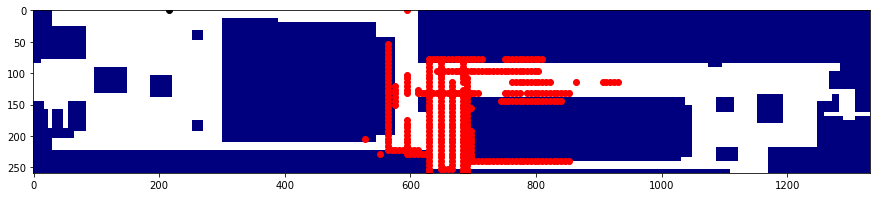

0 258 528 930
0.0 210.0


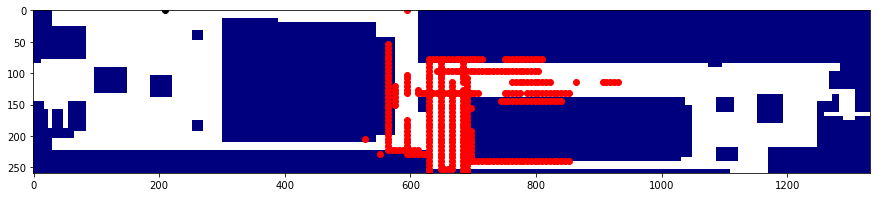

0 258 528 930
0.0 204.0


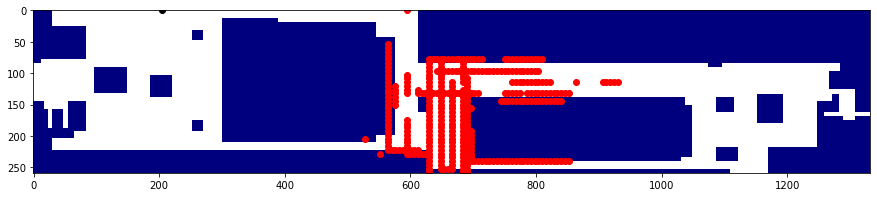

78 240 630 1092
246.0 882.0


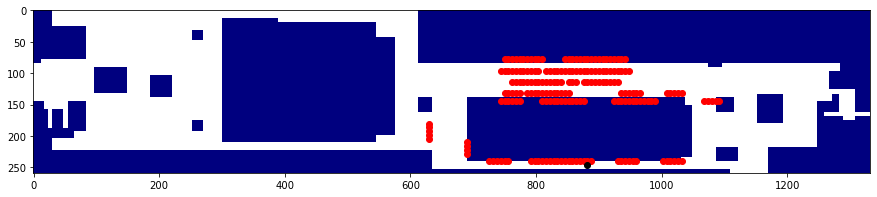

78 240 630 1092
246.0 888.0


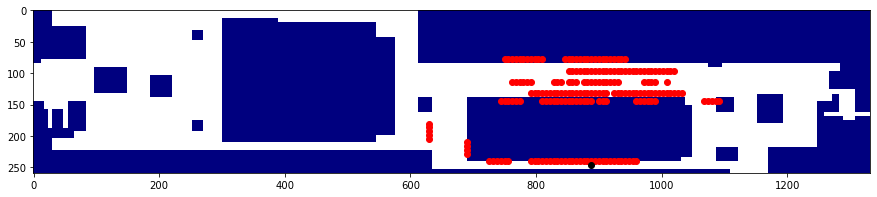

78 240 630 1092
246.0 894.0


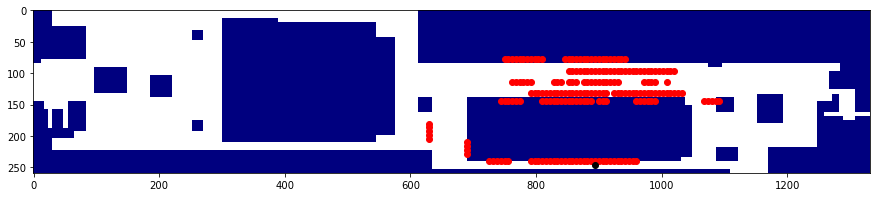

78 240 630 1092
246.0 900.0


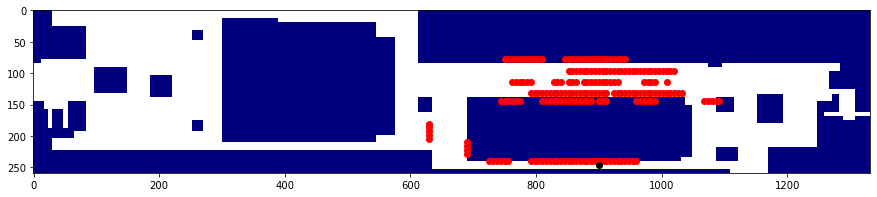

78 240 630 1092
246.0 906.0


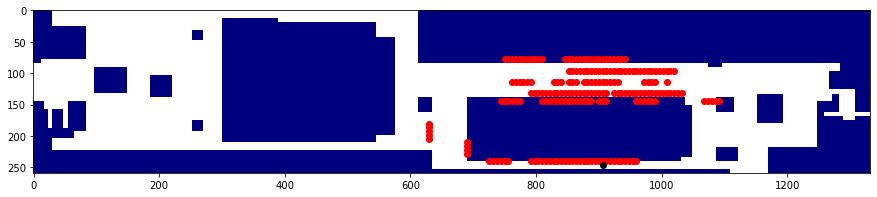

78 240 630 1092
246.0 912.0


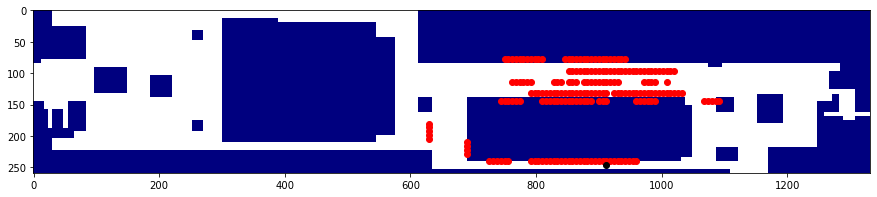

78 240 630 1092
246.0 918.0


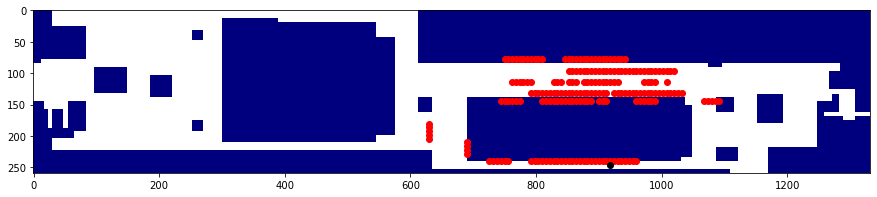

78 240 726 1164
246.0 924.0


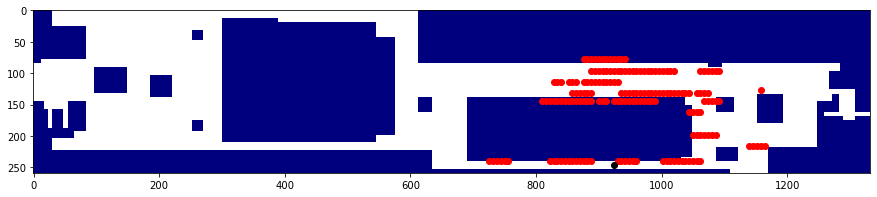

78 240 726 1164
246.0 930.0


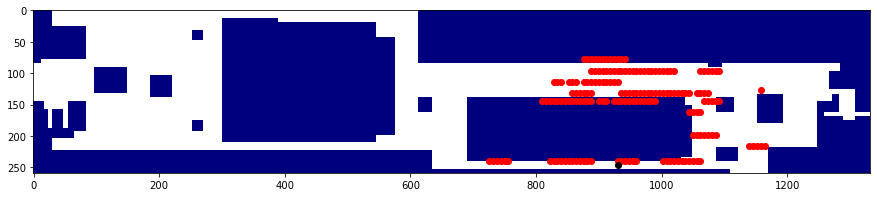

78 240 726 1164
246.0 936.0


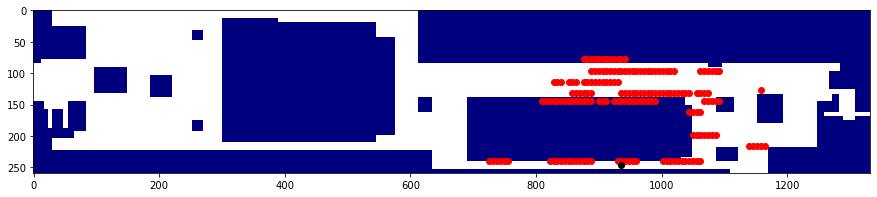

78 240 726 1164
246.0 942.0


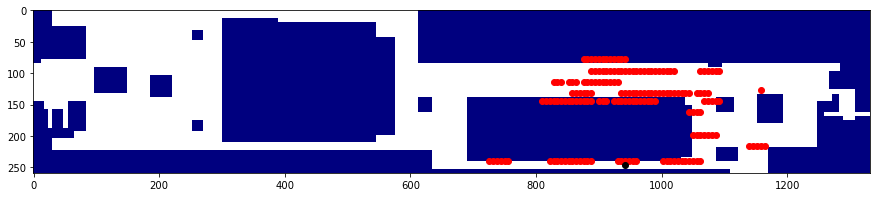

78 240 726 1164
246.0 948.0


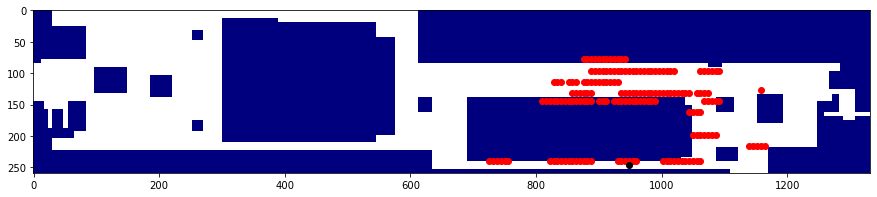

78 240 726 1164
246.0 954.0


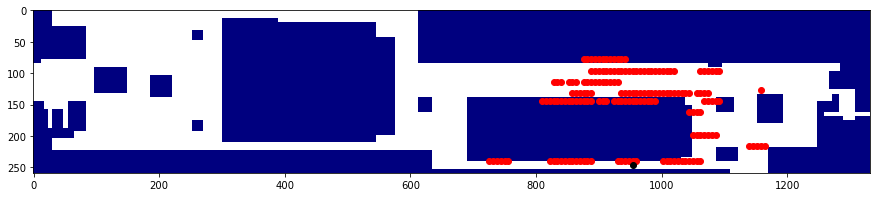

78 240 822 1260
246.0 960.0


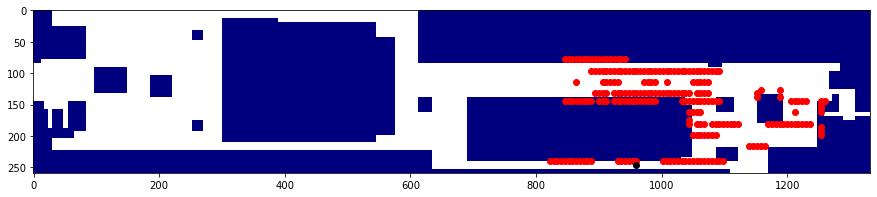

78 240 822 1260
246.0 966.0


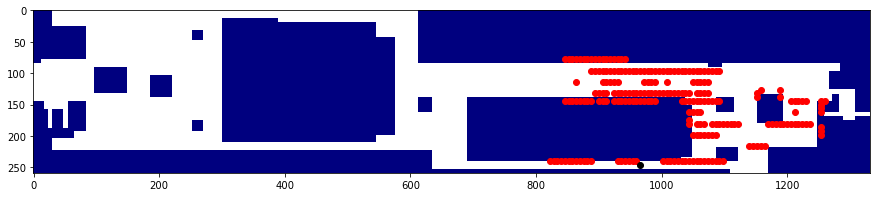

78 240 822 1260
246.0 972.0


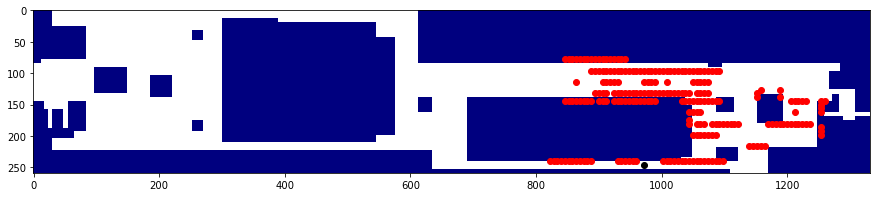

78 240 822 1260
246.0 978.0


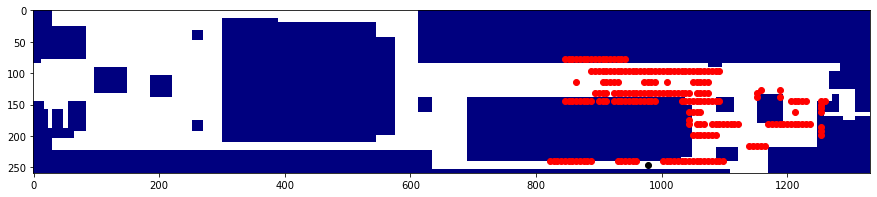

78 240 822 1260
246.0 984.0


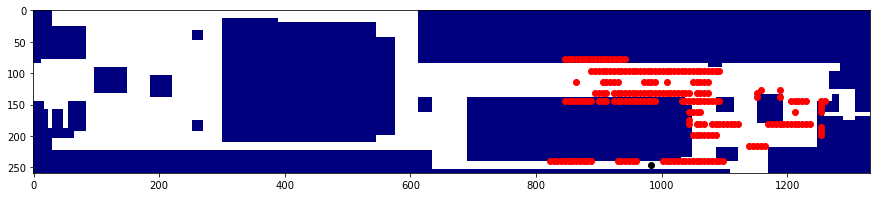

78 240 822 1260
246.0 990.0


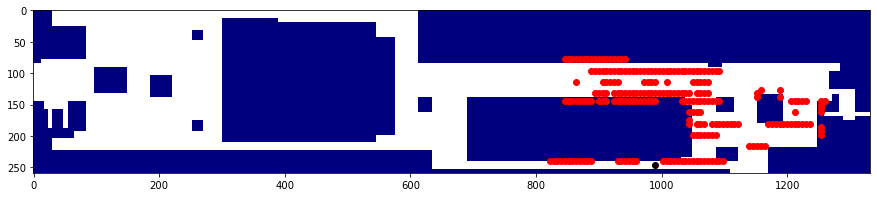

78 240 864 1230
246.0 996.0


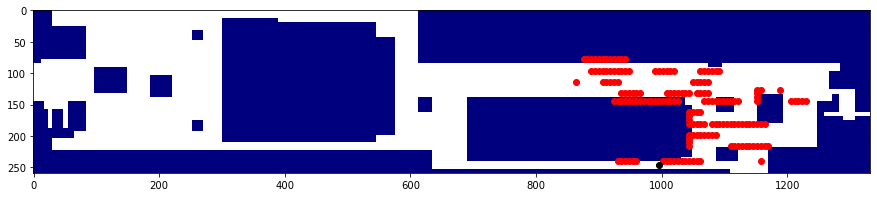

78 240 780 1200
246.0 1002.0


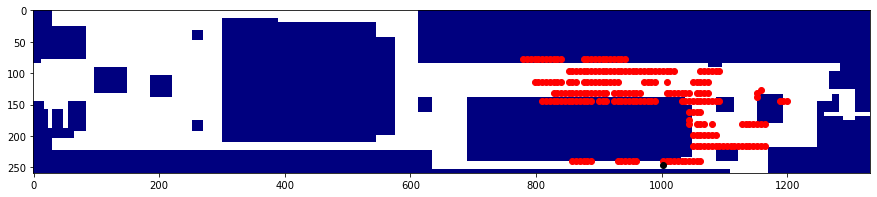

78 240 780 1200
246.0 1008.0


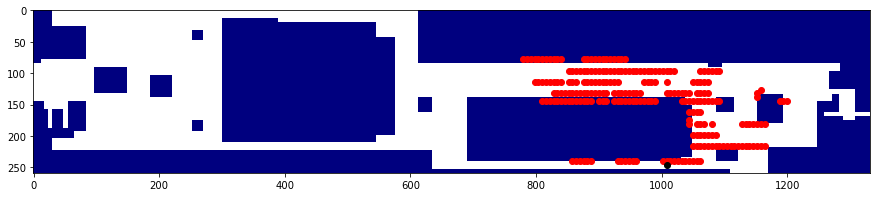

78 240 780 1200
246.0 1014.0


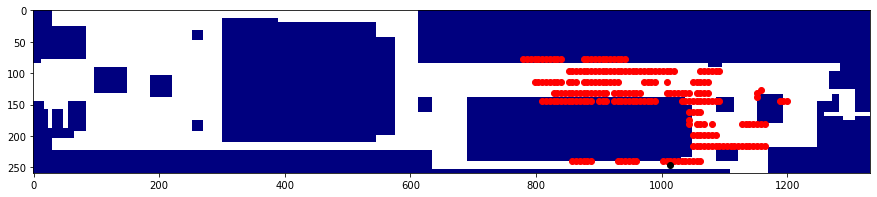

78 240 780 1200
246.0 1020.0


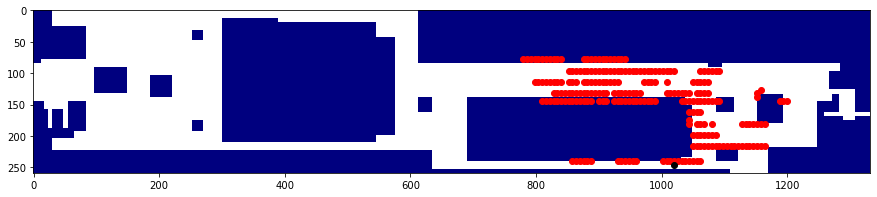

78 240 780 1200
246.0 1026.0


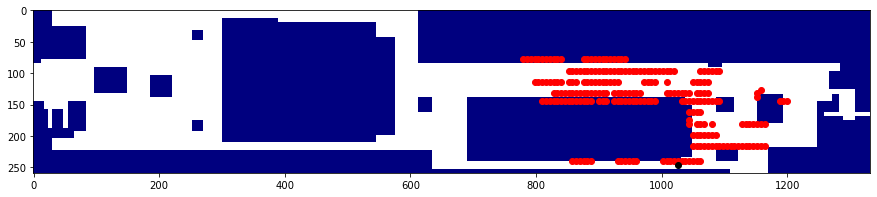

78 240 864 1254
246.0 1032.0


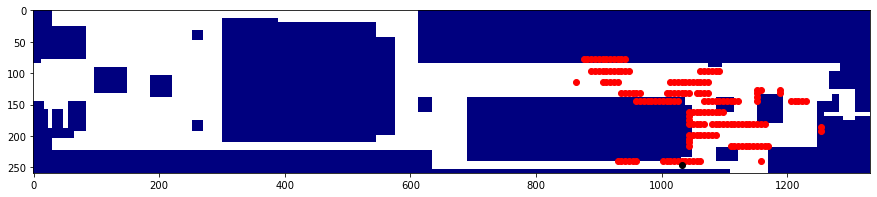

78 240 780 1260
246.0 1038.0


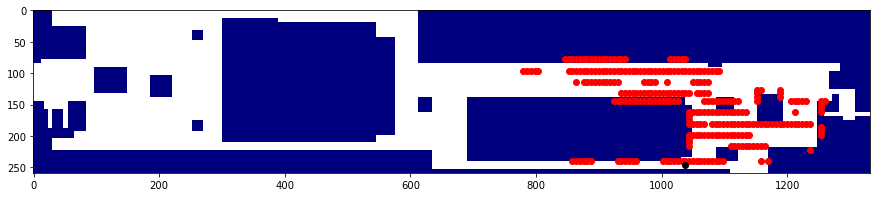

78 240 780 1260
246.0 1044.0


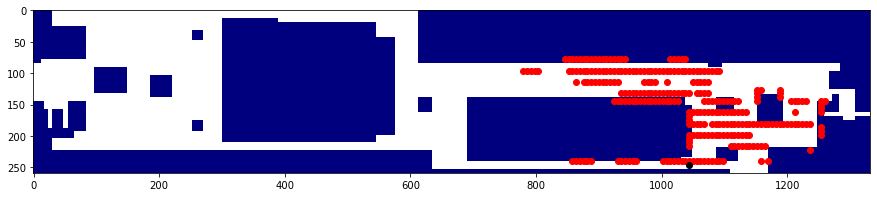

78 240 780 1260
246.0 1050.0


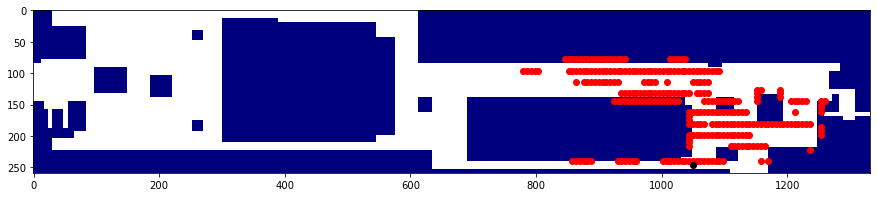

In [11]:
for i in range(len(fail)):
    x_list = fail[i][2][0]
    y_list = fail[i][2][1]
    
    ans_x = fail[i][0]
    ans_y = fail[i][1]
    
    print(min(x_list), max(x_list), min(y_list), max(y_list))

    # org_x_list = orig_coord[0]
    # org_y_list = orig_coord[1]

    print(ans_x, ans_y)
    
#     flt_x, flt_y = make_range2(x_list, y_list)

    # plt.figure(figsize = (15, 11))
    # plt.imshow(mag_df, cmap='jet', interpolation='none')
    # plt.scatter(org_y_list, org_x_list, c = 'b')
    # plt.scatter(y, x, c = 'r')


    plt.figure(figsize = (15, 11))
    plt.imshow(model.mag_df, cmap='jet', interpolation='none')
    plt.scatter(y_list, x_list, c = 'r')
    plt.scatter(ans_y, ans_x, c = 'black')

    plt.show()
    
#     plt.figure(figsize = (15, 11))
#     plt.imshow(model.mag_df, cmap='jet', interpolation='none')
#     plt.scatter(flt_y, flt_x, c = 'r')
#     plt.scatter(ans_y, ans_x, c = 'black')

#     plt.show()

In [9]:
for i in range(len(tot_acc_list)):
    print(inverse_thres_list[i])
    print(tot_acc_list[i])
    print(tot_list_area[i])
    plt.figure(figsize = (8, 4))
    plt.plot(inverse_range_list,tot_acc_list[i])
    plt.plot(inverse_range_list,tot_list_area[i])
    plt.scatter(inverse_range_list, tot_acc_list[i])
    plt.scatter(inverse_range_list, tot_list_area[i])
    plt.show()

In [10]:
basic_thres_list = [-63]
inverse_thres_list = [-60]
basic_range = 4
inverse_range_list = [5, 6, 7, 8]

model = wifimodel('포스코센터')

FileNotFoundError: [Errno 2] No such file or directory: '../../data/포스코센터/testH/'

In [11]:
tot_acc_list = []
tot_list_area = []
tot_area_dist = []

model.create_refwifi(basic_thres_list[0])


for inverse_thres in inverse_thres_list:
    model.create_inverse_refwifi(inverse_thres)
    acc_list = []
    list_area = []
    area_dist = []
    for inverse_range in inverse_range_list:
        model.define_range(basic_range, inverse_range)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

NameError: name 'model' is not defined

-57
[0.9910554561717353, 0.9946332737030411, 0.9946332737030411, 0.9946332737030411]
[0.24052188283679374, 0.26079733177370895, 0.2686515772161284, 0.2691708801203801]


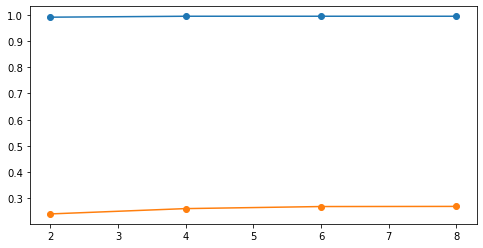

-60
[0.957680250783699, 0.9952978056426333, 0.9952978056426333, 0.9952978056426333]
[0.22915949589107237, 0.2652586352133286, 0.27810591111888877, 0.28308015197335956]


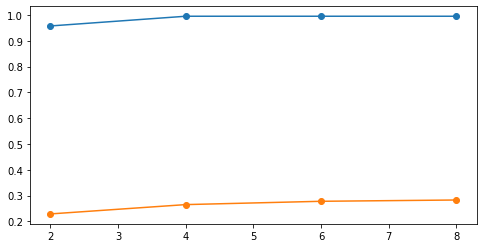

-63
[0.9186746987951807, 0.9879518072289156, 0.9954819277108434, 0.9954819277108434]
[0.19297186471439048, 0.23509054351826023, 0.2646189675503736, 0.27937590884908653]


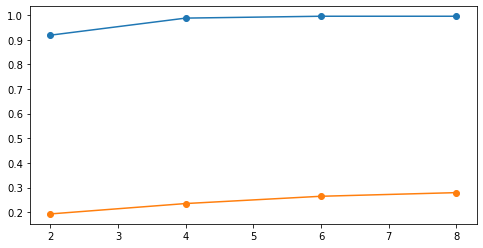

-66
[0.8023426061493412, 0.9663250366032211, 0.9956076134699854, 0.9956076134699854]
[0.17109496070294664, 0.20460197534466104, 0.2331446931685226, 0.2578884103265198]


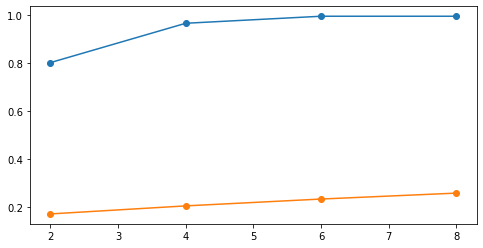

In [15]:
for i in range(len(tot_acc_list)):
    print(inverse_thres_list[i])
    print(tot_acc_list[i])
    print(tot_list_area[i])
    plt.figure(figsize = (8, 4))
    plt.plot(inverse_range_list,tot_acc_list[i])
    plt.plot(inverse_range_list,tot_list_area[i])
    plt.scatter(inverse_range_list, tot_acc_list[i])
    plt.scatter(inverse_range_list, tot_list_area[i])
    plt.show()

-60
[0.47144948755490484, 0.767203513909224, 0.9194729136163983, 0.9780380673499268]
[0.16042459978288656, 0.17852502413528165, 0.19321719247656147, 0.2140928037132627]


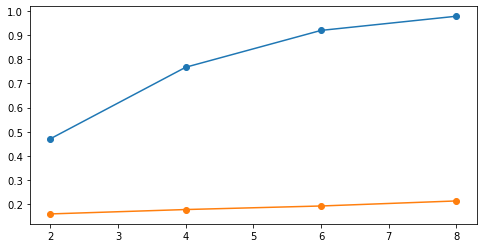

-63
[0.47144948755490484, 0.767203513909224, 0.9194729136163983, 0.9780380673499268]
[0.16042459978288656, 0.17852502413528165, 0.19321719247656147, 0.2140928037132627]


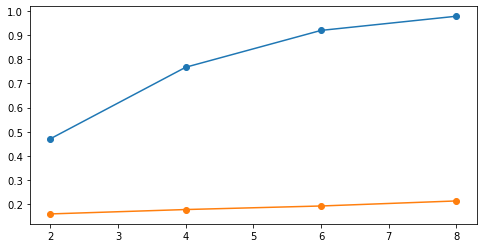

-66
[0.47144948755490484, 0.767203513909224, 0.9194729136163983, 0.9780380673499268]
[0.16042459978288656, 0.17852502413528165, 0.19321719247656147, 0.2140928037132627]


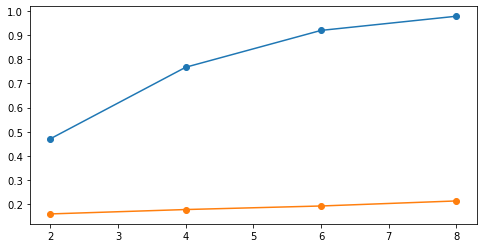

-69
[0.47144948755490484, 0.767203513909224, 0.9194729136163983, 0.9780380673499268]
[0.16042459978288656, 0.17852502413528165, 0.19321719247656147, 0.2140928037132627]


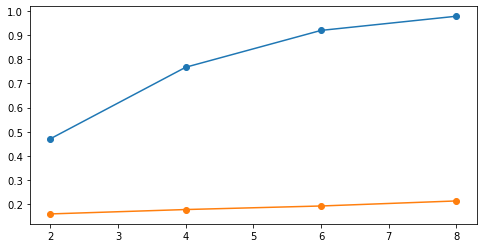

-72
[0.47144948755490484, 0.767203513909224, 0.9194729136163983, 0.9780380673499268]
[0.16042459978288656, 0.17852502413528165, 0.19321719247656147, 0.2140928037132627]


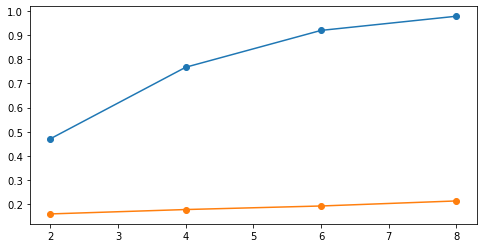

-75
[0.47144948755490484, 0.767203513909224, 0.9194729136163983, 0.9780380673499268]
[0.16042459978288656, 0.17852502413528165, 0.19321719247656147, 0.2140928037132627]


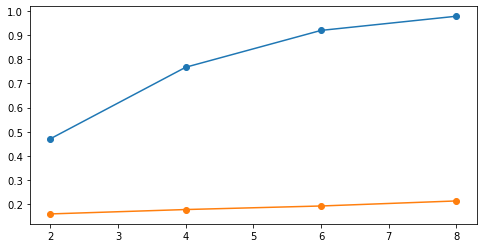

In [65]:
for i in range(len(tot_acc_list)):
    print(inverse_thres_list[i])
    print(tot_acc_list[i])
    print(tot_list_area[i])
    plt.figure(figsize = (8, 4))
    plt.plot(inverse_range_list,tot_acc_list[i])
    plt.plot(inverse_range_list,tot_list_area[i])
    plt.scatter(inverse_range_list, tot_acc_list[i])
    plt.scatter(inverse_range_list, tot_list_area[i])
    plt.show()

In [66]:
basic_thres_list = [-75]
inverse_thres_list = [-78, -81, -84, -87, -90]
basic_range = 6
inverse_range_list = [2, 4, 6, 8]

model = wifimodel('하나스퀘어')

In [67]:
tot_acc_list = []
tot_list_area = []
tot_area_dist = []

model.create_refwifi(basic_thres_list[0])


for inverse_thres in inverse_thres_list:
    model.create_inverse_refwifi(inverse_thres)
    acc_list = []
    list_area = []
    area_dist = []
    for inverse_range in inverse_range_list:
        model.define_range(basic_range, inverse_range)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 50 회
성공 횟수 : 0회
현재 진행 상황 : 100 회
성공 횟수 : 5회
현재 진행 상황 : 150 회
성공 횟수 : 34회
현재 진행 상황 : 200 회
성공 횟수 : 39회
현재 진행 상황 : 250 회
성공 횟수 : 42회
현재 진행 상황 : 300 회
성공 횟수 : 51회
현재 진행 상황 : 350 회
성공 횟수 : 55회
현재 진행 상황 : 400 회
성공 횟수 : 69회
현재 진행 상황 : 450 회
성공 횟수 : 95회
현재 진행 상황 : 500 회
성공 횟수 : 100회
현재 진행 상황 : 550 회
성공 횟수 : 106회
현재 진행 상황 : 600 회
성공 횟수 : 107회
현재 진행 상황 : 650 회
성공 횟수 : 112회
test 횟수 : 694, 성공 횟수 : 131
18.876080691642652
0.06263394962478132
현재 진행 상황 : 50 회
성공 횟수 : 12회
현재 진행 상황 : 100 회
성공 횟수 : 39회
현재 진행 상황 : 150 회
성공 횟수 : 81회
현재 진행 상황 : 200 회
성공 횟수 : 99회
현재 진행 상황 : 250 회
성공 횟수 : 105회
현재 진행 상황 : 300 회
성공 횟수 : 126회
현재 진행 상황 : 350 회
성공 횟수 : 151회
현재 진행 상황 : 400 회
성공 횟수 : 169회
현재 진행 상황 : 450 회
성공 횟수 : 208회
현재 진행 상황 : 500 회
성공 횟수 : 229회
현재 진행 상황 : 550 회
성공 횟수 : 262회
현재 진행 상황 : 600 회
성공 횟수 : 271회
현재 진행 상황 : 650 회
성공 횟수 : 301회
test 횟수 : 694, 성공 횟수 : 329
47.40634005763689
0.11646045613808069
현재 진행 상황 : 50 회
성공 횟수 : 28회
현재 진행 상황 : 100 회
성공 횟수 : 58회
현재 진행 상황 : 150 회
성공 횟수 : 103회
현재 진행 상황 : 200 회
성공

현재 진행 상황 : 400 회
성공 횟수 : 162회
현재 진행 상황 : 450 회
성공 횟수 : 198회
현재 진행 상황 : 500 회
성공 횟수 : 223회
현재 진행 상황 : 550 회
성공 횟수 : 234회
현재 진행 상황 : 600 회
성공 횟수 : 243회
현재 진행 상황 : 650 회
성공 횟수 : 269회
test 횟수 : 694, 성공 횟수 : 297
42.79538904899135
0.1045835344409988
현재 진행 상황 : 50 회
성공 횟수 : 21회
현재 진행 상황 : 100 회
성공 횟수 : 41회
현재 진행 상황 : 150 회
성공 횟수 : 89회
현재 진행 상황 : 200 회
성공 횟수 : 119회
현재 진행 상황 : 250 회
성공 횟수 : 132회
현재 진행 상황 : 300 회
성공 횟수 : 163회
현재 진행 상황 : 350 회
성공 횟수 : 202회
현재 진행 상황 : 400 회
성공 횟수 : 235회
현재 진행 상황 : 450 회
성공 횟수 : 273회
현재 진행 상황 : 500 회
성공 횟수 : 311회
현재 진행 상황 : 550 회
성공 횟수 : 337회
현재 진행 상황 : 600 회
성공 횟수 : 350회
현재 진행 상황 : 650 회
성공 횟수 : 377회
test 횟수 : 694, 성공 횟수 : 411
59.221902017291065
0.136001646890318


-78
[0.18876080691642652, 0.47406340057636887, 0.659942363112392, 0.8328530259365994]
[0.06263394962478132, 0.11646045613808069, 0.14709484051055252, 0.1600124149619655]


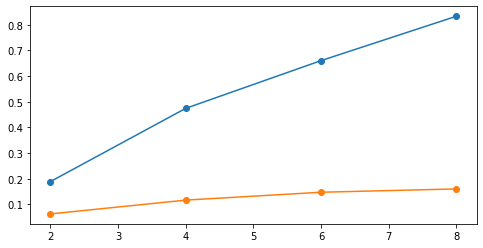

-81
[0.14121037463976946, 0.3314121037463977, 0.5763688760806917, 0.7449567723342939]
[0.03991960089147651, 0.08615956238514051, 0.12620494892062786, 0.1551433540707455]


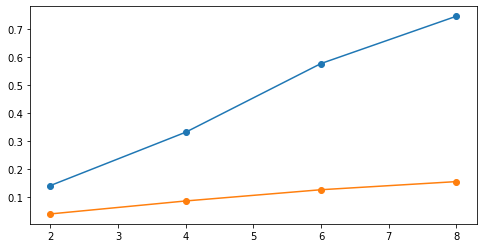

-84
[0.059077809798270896, 0.22622478386167147, 0.42795389048991356, 0.6368876080691642]
[0.03366751848994361, 0.05158267655102054, 0.1032121842324393, 0.13479996949393713]


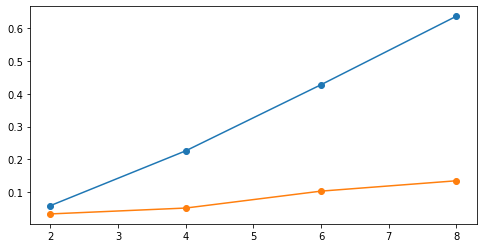

-87
[0.03170028818443804, 0.1873198847262248, 0.3631123919308357, 0.521613832853026]
[0.010820711495880285, 0.04337362927010338, 0.0752095083892319, 0.11184161897254537]


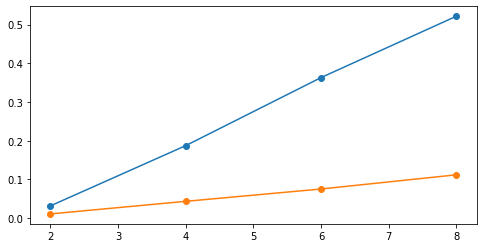

-90
[0.04178674351585014, 0.20461095100864554, 0.42795389048991356, 0.5922190201729106]
[0.008259154390514818, 0.06612461207095782, 0.1045835344409988, 0.136001646890318]


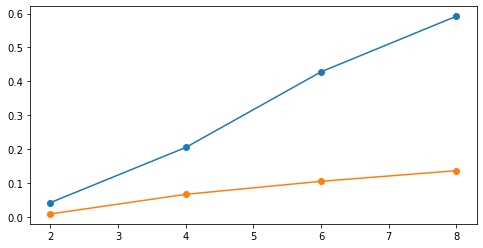

In [68]:
for i in range(len(tot_acc_list)):
    print(inverse_thres_list[i])
    print(tot_acc_list[i])
    print(tot_list_area[i])
    plt.figure(figsize = (8, 4))
    plt.plot(inverse_range_list,tot_acc_list[i])
    plt.plot(inverse_range_list,tot_list_area[i])
    plt.scatter(inverse_range_list, tot_acc_list[i])
    plt.scatter(inverse_range_list, tot_list_area[i])
    plt.show()

In [60]:
basic_thres_list = [-78]
inverse_thres_list = [-51, -54, -57]
basic_range = 2
inverse_range_list = [2, 4, 6, 8]

model = wifimodel('포스코실험동')

In [61]:
tot_acc_list = []
tot_list_area = []
tot_area_dist = []

model.create_refwifi(basic_thres_list[0])


for inverse_thres in inverse_thres_list:
    model.create_inverse_refwifi(inverse_thres)
    acc_list = []
    list_area = []
    area_dist = []
    for inverse_range in inverse_range_list:
        model.define_range(basic_range, inverse_range)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 199회
현재 진행 상황 : 250 회
성공 횟수 : 247회
현재 진행 상황 : 300 회
성공 횟수 : 295회
현재 진행 상황 : 350 회
성공 횟수 : 344회
현재 진행 상황 : 400 회
성공 횟수 : 394회
현재 진행 상황 : 450 회
성공 횟수 : 444회
현재 진행 상황 : 500 회
성공 횟수 : 494회
현재 진행 상황 : 550 회
성공 횟수 : 544회
현재 진행 상황 : 600 회
성공 횟수 : 594회
현재 진행 상황 : 650 회
성공 횟수 : 644회
test 횟수 : 655, 성공 횟수 : 649
99.08396946564885
0.6556135541330481
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
현재 진행 상황 : 300 회
성공 횟수 : 300회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 : 450 회
성공 횟수 : 450회
현재 진행 상황 : 500 회
성공 횟수 : 500회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 650 회
성공 횟수 : 650회
test 횟수 : 655, 성공 횟수 : 655
100.0
0.6732075396804407
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 

-51
[0.9908396946564886, 1.0, 1.0, 1.0]
[0.6556135541330481, 0.6732075396804407, 0.6742994899130115, 0.6742994899130115]


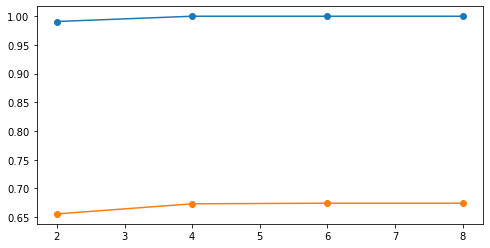

-54
[0.9893129770992366, 1.0, 1.0, 1.0]
[0.6245648890224285, 0.6742994899130115, 0.6742994899130115, 0.6742994899130115]


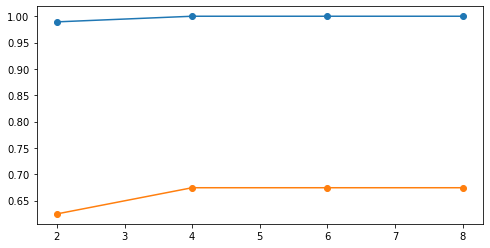

-57
[0.9847328244274809, 1.0, 1.0, 1.0]
[0.6527399781218721, 0.6741478301584877, 0.6742994899130115, 0.6742994899130115]


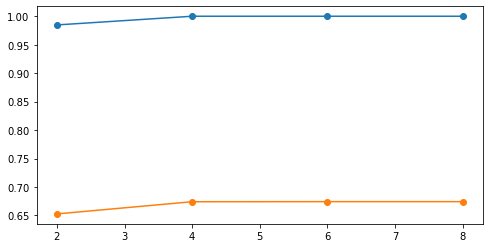

In [62]:
for i in range(len(tot_acc_list)):
    print(inverse_thres_list[i])
    print(tot_acc_list[i])
    print(tot_list_area[i])
    plt.figure(figsize = (8, 4))
    plt.plot(inverse_range_list,tot_acc_list[i])
    plt.plot(inverse_range_list,tot_list_area[i])
    plt.scatter(inverse_range_list, tot_acc_list[i])
    plt.scatter(inverse_range_list, tot_list_area[i])
    plt.show()

In [69]:
basic_thres_list = [-75]
inverse_thres_list = [-60, -63, -66, -69, -72, -75, -78, -81]
basic_range = 6
inverse_range_list = [10, 12, 14]

model = wifimodel('하나스퀘어')

In [70]:
tot_acc_list = []
tot_list_area = []
tot_area_dist = []

model.create_refwifi(basic_thres_list[0])


for inverse_thres in inverse_thres_list:
    model.create_inverse_refwifi(inverse_thres)
    acc_list = []
    list_area = []
    area_dist = []
    for inverse_range in inverse_range_list:
        model.define_range(basic_range, inverse_range)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 50 회
성공 횟수 : 47회
현재 진행 상황 : 100 회
성공 횟수 : 97회
현재 진행 상황 : 150 회
성공 횟수 : 147회
현재 진행 상황 : 200 회
성공 횟수 : 197회
현재 진행 상황 : 250 회
성공 횟수 : 246회
현재 진행 상황 : 300 회
성공 횟수 : 296회
현재 진행 상황 : 350 회
성공 횟수 : 345회
현재 진행 상황 : 400 회
성공 횟수 : 391회
현재 진행 상황 : 450 회
성공 횟수 : 440회
현재 진행 상황 : 500 회
성공 횟수 : 490회
현재 진행 상황 : 550 회
성공 횟수 : 540회
현재 진행 상황 : 600 회
성공 횟수 : 590회
test 횟수 : 638, 성공 횟수 : 628
98.43260188087774
0.280768966311371
현재 진행 상황 : 50 회
성공 횟수 : 47회
현재 진행 상황 : 100 회
성공 횟수 : 97회
현재 진행 상황 : 150 회
성공 횟수 : 147회
현재 진행 상황 : 200 회
성공 횟수 : 197회
현재 진행 상황 : 250 회
성공 횟수 : 246회
현재 진행 상황 : 300 회
성공 횟수 : 296회
현재 진행 상황 : 350 회
성공 횟수 : 345회
현재 진행 상황 : 400 회
성공 횟수 : 391회
현재 진행 상황 : 450 회
성공 횟수 : 440회
현재 진행 상황 : 500 회
성공 횟수 : 490회
현재 진행 상황 : 550 회
성공 횟수 : 540회
현재 진행 상황 : 600 회
성공 횟수 : 590회
test 횟수 : 638, 성공 횟수 : 628
98.43260188087774
0.28260088655442267
현재 진행 상황 : 50 회
성공 횟수 : 47회
현재 진행 상황 : 100 회
성공 횟수 : 97회
현재 진행 상황 : 150 회
성공 횟수 : 147회
현재 진행 상황 : 200 회
성공 횟수 : 197회
현재 진행 상황 : 250 회
성공 횟수 : 246회
현재 진행 상황 : 

KeyboardInterrupt: 

In [ ]:
for i in range(len(tot_acc_list)):
    print(inverse_thres_list[i])
    print(tot_acc_list[i])
    print(tot_list_area[i])
    plt.figure(figsize = (8, 4))
    plt.plot(inverse_range_list,tot_acc_list[i])
    plt.plot(inverse_range_list,tot_list_area[i])
    plt.scatter(inverse_range_list, tot_acc_list[i])
    plt.scatter(inverse_range_list, tot_list_area[i])
    plt.show()

In [9]:
tot_acc_list = []
tot_list_area = []
tot_area_dist = []
for thres in thres_list:
    model.create_refwifi(thres)
    acc_list = []
    list_area = []
    area_dist = []
    for rang in range_val:
        model.define_range(rang)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 50 회
성공 횟수 : 39회
현재 진행 상황 : 100 회
성공 횟수 : 78회
현재 진행 상황 : 150 회
성공 횟수 : 121회
현재 진행 상황 : 200 회
성공 횟수 : 169회
현재 진행 상황 : 250 회
성공 횟수 : 213회
test 횟수 : 253, 성공 횟수 : 216
85.37549407114625
0.12200621114646058
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
test 횟수 : 253, 성공 횟수 : 253
100.0
0.20094330643453204
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
test 횟수 : 253, 성공 횟수 : 253
100.0
0.6092432496803627
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
test 횟수 : 253, 성공 횟수 : 253
100.0
0.7267500225095095
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
test 횟수 : 253, 성공 횟수 : 253
100.0
0.8880

-60
[0.8537549407114624, 1.0, 1.0, 1.0, 1.0]
[0.12200621114646058, 0.20094330643453204, 0.6092432496803627, 0.7267500225095095, 0.8880372609662013]


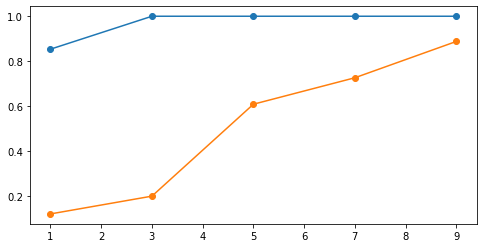

-63
[0.7707509881422925, 0.9367588932806324, 1.0, 1.0, 1.0]
[0.11510457597814716, 0.19622596048463872, 0.5173065083533898, 0.5607599835913549, 0.773656948135541]


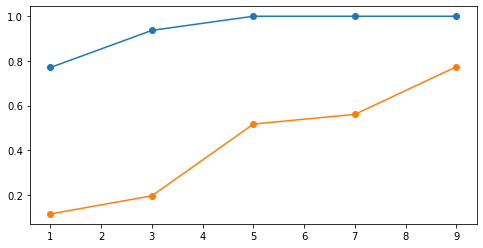

-66
[0.6996047430830039, 0.932806324110672, 0.9960474308300395, 1.0, 1.0]
[0.13050407439412753, 0.17872657993867855, 0.24444523591439424, 0.3216050738008783, 0.7265340854597867]


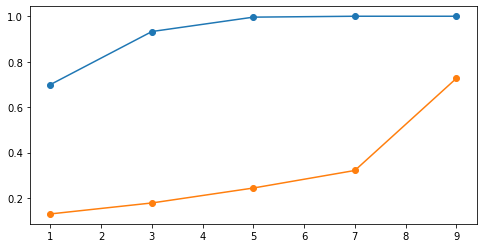

-69
[0.782608695652174, 1.0, 1.0, 1.0, 1.0]
[0.19533824043138057, 0.2929124383189636, 0.33294948094881455, 0.38894427155317934, 0.489156029107029]


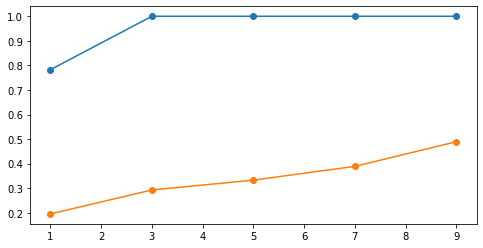

-72
[0.7470355731225297, 0.9762845849802372, 1.0, 1.0, 1.0]
[0.21012598050867604, 0.31100469093379357, 0.36986931802516737, 0.4384516962208724, 0.5925682822192698]


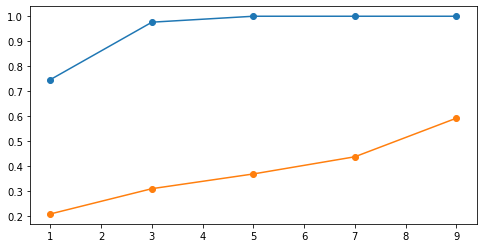

In [10]:
for i in range(len(tot_acc_list)):
    print(thres_list[i])
    print(tot_acc_list[i])
    print(tot_list_area[i])
    plt.figure(figsize = (8, 4))
    plt.plot(range_val,tot_acc_list[i])
    plt.plot(range_val,tot_list_area[i])
    plt.scatter(range_val, tot_acc_list[i])
    plt.scatter(range_val, tot_list_area[i])
    plt.show()

In [11]:
thres_list = [-75, -78, -81, -84, -87]
range_val = [1, 3, 5, 7, 9]#, 6, 7, 8, 9]
area_thres1 = 0.0
area_thres2 = 1.0

test_slicer = 1

model = wifimodel('포스코센터')

In [12]:
tot_acc_list = []
tot_list_area = []

tot_area_dist = []
for thres in thres_list:
    model.create_refwifi(thres)
    acc_list = []
    list_area = []
    area_dist = []
    for rang in range_val:
        model.define_range(rang)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 50 회
성공 횟수 : 11회
현재 진행 상황 : 100 회
성공 횟수 : 30회
현재 진행 상황 : 150 회
성공 횟수 : 59회
현재 진행 상황 : 200 회
성공 횟수 : 98회
현재 진행 상황 : 250 회
성공 횟수 : 135회
test 횟수 : 253, 성공 횟수 : 135
53.359683794466406
0.2271957161516907
현재 진행 상황 : 50 회
성공 횟수 : 41회
현재 진행 상황 : 100 회
성공 횟수 : 87회
현재 진행 상황 : 150 회
성공 횟수 : 135회
현재 진행 상황 : 200 회
성공 횟수 : 184회
현재 진행 상황 : 250 회
성공 횟수 : 233회
test 횟수 : 253, 성공 횟수 : 233
92.09486166007905
0.26502417496704067
현재 진행 상황 : 50 회
성공 횟수 : 49회
현재 진행 상황 : 100 회
성공 횟수 : 99회
현재 진행 상황 : 150 회
성공 횟수 : 149회
현재 진행 상황 : 200 회
성공 횟수 : 199회
현재 진행 상황 : 250 회
성공 횟수 : 248회
test 횟수 : 253, 성공 횟수 : 248
98.02371541501977
0.3840987237655289
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 249회
test 횟수 : 253, 성공 횟수 : 249
98.41897233201581
0.5093641596906794
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
test 횟수

-75
[0.5335968379446641, 0.9209486166007905, 0.9802371541501976, 0.9841897233201581, 1.0]
[0.2271957161516907, 0.26502417496704067, 0.3840987237655289, 0.5093641596906794, 0.5868397807716239]


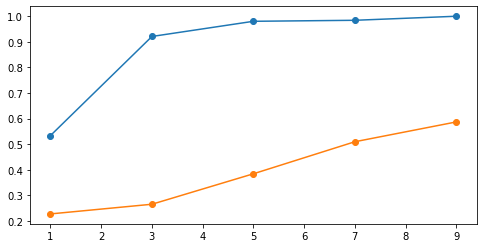

-78
[0.5889328063241107, 0.8932806324110671, 0.9367588932806324, 0.9802371541501976, 1.0]
[0.21586085582755396, 0.3103409127917108, 0.4455115524072256, 0.5209715795379386, 0.624865524024057]


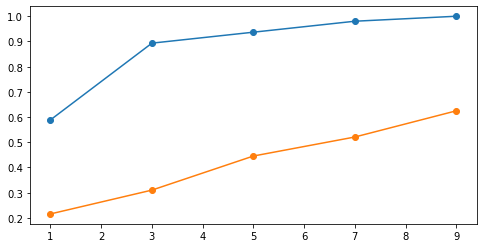

-81
[0.5573122529644269, 0.924901185770751, 1.0, 1.0, 1.0]
[0.27245878579939714, 0.3406049634973199, 0.4510392838122127, 0.5473271566910998, 0.6441417617305605]


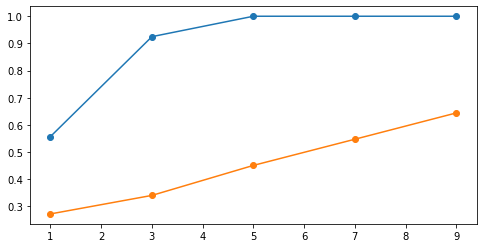

-84
[0.4505928853754941, 0.841897233201581, 0.9762845849802372, 0.9841897233201581, 1.0]
[0.2706529747979894, 0.3478416063759404, 0.42156670531289325, 0.5741719663099601, 0.6832302237491295]


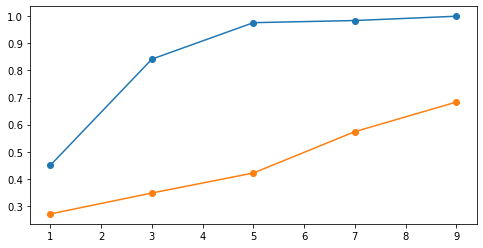

-87
[0.43478260869565216, 0.924901185770751, 0.9920948616600791, 1.0, 1.0]
[0.18435486803407805, 0.3406958501887149, 0.5372622902461922, 0.6909222099417545, 0.8211816079645295]


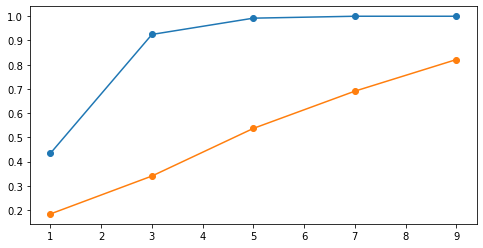

In [13]:
for i in range(len(tot_acc_list)):
    print(thres_list[i])
    print(tot_acc_list[i])
    print(tot_list_area[i])
    plt.figure(figsize = (8, 4))
    plt.plot(range_val,tot_acc_list[i])
    plt.plot(range_val,tot_list_area[i])
    plt.scatter(range_val, tot_acc_list[i])
    plt.scatter(range_val, tot_list_area[i])
    plt.show()

In [14]:
thres_list = [-90, -93, -96]
range_val = [1, 3, 5, 7, 9]#, 6, 7, 8, 9]
area_thres1 = 0.0
area_thres2 = 1.0

test_slicer = 1

model = wifimodel('포스코센터')

In [15]:
tot_acc_list = []
tot_list_area = []

tot_area_dist = []
for thres in thres_list:
    model.create_refwifi(thres)
    acc_list = []
    list_area = []
    area_dist = []
    for rang in range_val:
        model.define_range(rang)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 50 회
성공 횟수 : 21회
현재 진행 상황 : 100 회
성공 횟수 : 43회
현재 진행 상황 : 150 회
성공 횟수 : 63회
현재 진행 상황 : 200 회
성공 횟수 : 81회
현재 진행 상황 : 250 회
성공 횟수 : 98회
test 횟수 : 253, 성공 횟수 : 98
38.73517786561265
0.197471850799754
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 99회
현재 진행 상황 : 150 회
성공 횟수 : 149회
현재 진행 상황 : 200 회
성공 횟수 : 197회
현재 진행 상황 : 250 회
성공 횟수 : 244회
test 횟수 : 253, 성공 횟수 : 244
96.44268774703558
0.32505364095209144
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 248회
test 횟수 : 253, 성공 횟수 : 251
99.2094861660079
0.5623978636554823
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 249회
test 횟수 : 253, 성공 횟수 : 252
99.60474308300395
0.7920125368840052
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
test 횟수 : 2

-90
[0.38735177865612647, 0.9644268774703557, 0.9920948616600791, 0.9960474308300395, 1.0]
[0.197471850799754, 0.32505364095209144, 0.5623978636554823, 0.7920125368840052, 0.879334226658624]


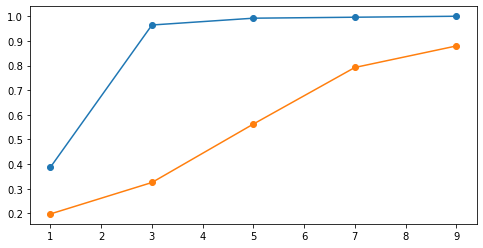

-93
[0.233201581027668, 0.849802371541502, 0.9723320158102767, 0.9960474308300395, 1.0]
[0.15730201040555808, 0.31093998954599433, 0.5533258239789172, 0.7466724065443897, 0.8772473493138032]


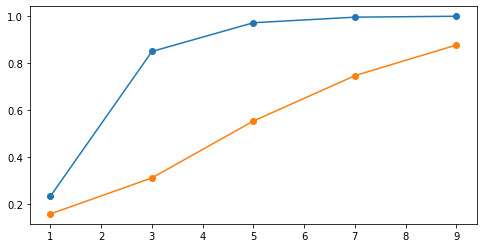

-96
[0.17391304347826086, 0.8537549407114624, 0.9525691699604744, 1.0, 1.0]
[0.18892853042776891, 0.272635545896181, 0.5205737114360626, 0.7723389609284831, 0.8915269579304713]


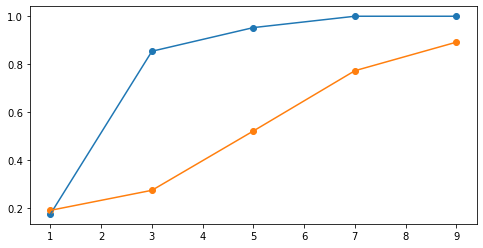

In [16]:
for i in range(len(tot_acc_list)):
    print(thres_list[i])
    print(tot_acc_list[i])
    print(tot_list_area[i])
    plt.figure(figsize = (8, 4))
    plt.plot(range_val,tot_acc_list[i])
    plt.plot(range_val,tot_list_area[i])
    plt.scatter(range_val, tot_acc_list[i])
    plt.scatter(range_val, tot_list_area[i])
    plt.show()

In [18]:
thres_list = [-96, -93, -90, -87, -84, -81, -78, -75]
range_val = [1, 2, 3, 4, 5]#, 6, 7, 8, 9]
area_thres1 = 0.0
area_thres2 = 1.0

test_slicer = 1

model = wifimodel('포스코센터')

In [19]:
tot_acc_list = []
tot_list_area = []

tot_area_dist = []
for thres in thres_list:
    model.create_refwifi_thres_reverse(thres)
    acc_list = []
    list_area = []
    area_dist = []
    for rang in range_val:
        model.define_range(rang)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

test 횟수 : 41, 성공 횟수 : 35
85.36585365853658
0.5408575284406553
test 횟수 : 41, 성공 횟수 : 38
92.6829268292683
0.6181228896464634
test 횟수 : 41, 성공 횟수 : 38
92.6829268292683
0.6181228896464634
test 횟수 : 41, 성공 횟수 : 38
92.6829268292683
0.6181228896464634
test 횟수 : 41, 성공 횟수 : 38
92.6829268292683
0.6181228896464634
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
test 횟수 : 152, 성공 횟수 : 152
100.0
0.9950841973475262
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
test 횟수 : 152, 성공 횟수 : 152
100.0
0.9950841973475262
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
test 횟수 : 152, 성공 횟수 : 152
100.0
0.9950841973475262
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
test 횟수 : 152, 성공 횟수 : 152
100.0
0.9950841973475262
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
test 횟수 : 152, 성공 횟수 : 152
100.0
0.99508419734

-96
[0.8536585365853658, 0.926829268292683, 0.926829268292683, 0.926829268292683, 0.926829268292683]
[0.5408575284406553, 0.6181228896464634, 0.6181228896464634, 0.6181228896464634, 0.6181228896464634]


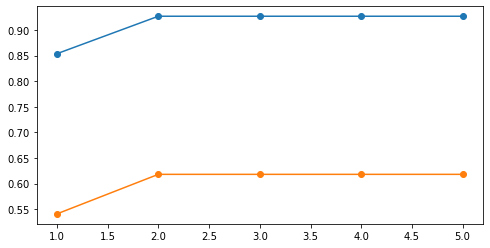

-93
[1.0, 1.0, 1.0, 1.0, 1.0]
[0.9950841973475262, 0.9950841973475262, 0.9950841973475262, 0.9950841973475262, 0.9950841973475262]


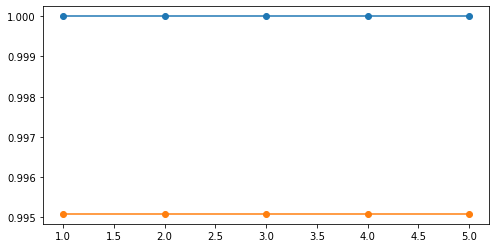

-90
[0.8024691358024691, 1.0, 1.0, 1.0, 1.0]
[0.8091550414389114, 0.9180019065822859, 0.9293233680384304, 0.9950841973475257, 0.9950841973475257]


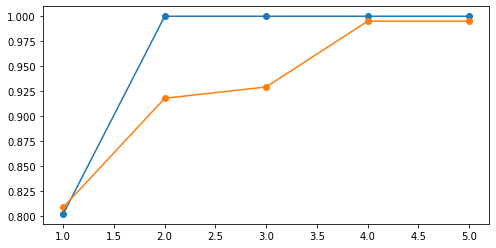

-87
[0.332, 0.624, 0.84, 0.96, 1.0]
[0.13380861704989025, 0.3743372671706014, 0.6168054018856426, 0.8588877386765813, 0.9204630285029837]


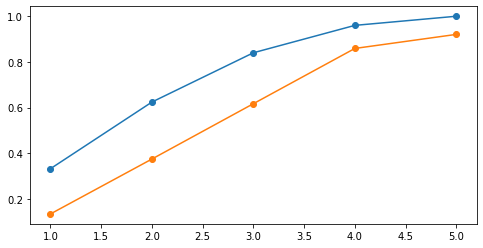

-84
[0.11462450592885376, 0.2885375494071146, 0.38735177865612647, 0.5217391304347826, 0.6324110671936759]
[0.029051883462789852, 0.07313053645883873, 0.12609178148542122, 0.19145023815307324, 0.2930340041299246]


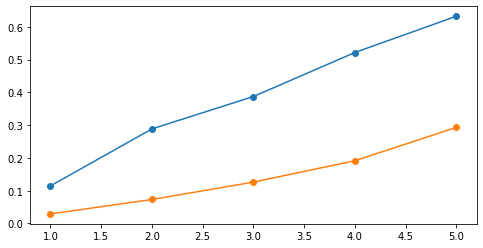

-81
[0.06324110671936758, 0.2490118577075099, 0.32806324110671936, 0.35177865612648224, 0.45849802371541504]
[0.046108006742291624, 0.056183698798884116, 0.08254050634837311, 0.09968380359857239, 0.1185085399058778]


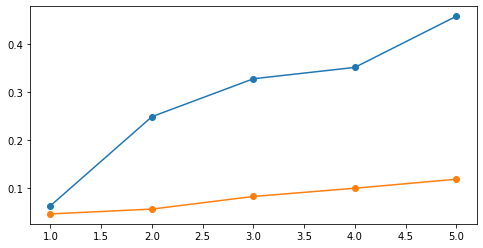

-78
[0.07114624505928854, 0.2924901185770751, 0.3241106719367589, 0.45454545454545453, 0.549407114624506]
[0.03060046502300726, 0.08588204153684054, 0.10723210052047728, 0.14307495344232257, 0.19296969216780804]


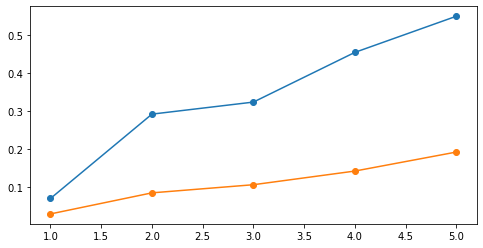

-75
[0.07509881422924901, 0.2964426877470356, 0.48221343873517786, 0.6284584980237155, 0.7430830039525692]
[0.03765710786040638, 0.06456730638945948, 0.12996068299687774, 0.16559212203535564, 0.20007128830607704]


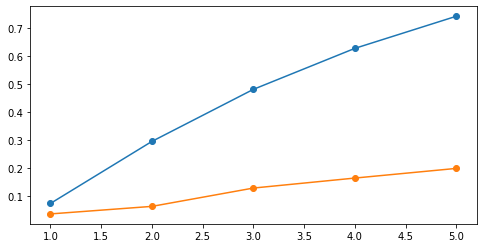

In [20]:
for i in range(len(tot_acc_list)):
    print(thres_list[i])
    print(tot_acc_list[i])
    print(tot_list_area[i])
    plt.figure(figsize = (8, 4))
    plt.plot(range_val,tot_acc_list[i])
    plt.plot(range_val,tot_list_area[i])
    plt.scatter(range_val, tot_acc_list[i])
    plt.scatter(range_val, tot_list_area[i])
    plt.show()

In [27]:
thres_list = [-84, -81, -78, -75, -72, -69, -66]
range_val = [2]#, 6, 7, 8, 9]
section_len_list = [5, 8, 11, 14]
area_thres1 = 0.0
area_thres2 = 1.0

test_slicer = 1

model = wifimodel('포스코센터')

In [28]:
tot_acc_list = []
tot_list_area = []

tot_area_dist = []
for thres in thres_list:
    acc_list = []
    list_area = []
    area_dist = []
    for section_len in section_len_list:
        model.create_refwifi_thres_section(thres, section_len)
        model.define_range(range_val[0])
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 50 회
성공 횟수 : 24회
현재 진행 상황 : 100 회
성공 횟수 : 70회
현재 진행 상황 : 150 회
성공 횟수 : 120회
현재 진행 상황 : 200 회
성공 횟수 : 159회
현재 진행 상황 : 250 회
성공 횟수 : 195회
test 횟수 : 253, 성공 횟수 : 195
77.07509881422925
0.29047953569408047
현재 진행 상황 : 50 회
성공 횟수 : 19회
현재 진행 상황 : 100 회
성공 횟수 : 62회
현재 진행 상황 : 150 회
성공 횟수 : 103회
현재 진행 상황 : 200 회
성공 횟수 : 123회
현재 진행 상황 : 250 회
성공 횟수 : 151회
test 횟수 : 253, 성공 횟수 : 151
59.683794466403164
0.11495477279940958
현재 진행 상황 : 50 회
성공 횟수 : 34회
현재 진행 상황 : 100 회
성공 횟수 : 75회
현재 진행 상황 : 150 회
성공 횟수 : 119회
현재 진행 상황 : 200 회
성공 횟수 : 153회
현재 진행 상황 : 250 회
성공 횟수 : 186회
test 횟수 : 253, 성공 횟수 : 186
73.51778656126483
0.07912839044309361
현재 진행 상황 : 50 회
성공 횟수 : 42회
현재 진행 상황 : 100 회
성공 횟수 : 79회
현재 진행 상황 : 150 회
성공 횟수 : 110회
현재 진행 상황 : 200 회
성공 횟수 : 141회
현재 진행 상황 : 250 회
성공 횟수 : 175회
test 횟수 : 253, 성공 횟수 : 175
69.1699604743083
0.051303976852601026
현재 진행 상황 : 50 회
성공 횟수 : 19회
현재 진행 상황 : 100 회
성공 횟수 : 69회
현재 진행 상황 : 150 회
성공 횟수 : 116회
현재 진행 상황 : 200 회
성공 횟수 : 145회
test 횟수 : 242, 성공 횟수 : 182
75.2066

-84
[0.7707509881422925, 0.5968379446640316, 0.7351778656126482, 0.691699604743083]
[0.29047953569408047, 0.11495477279940958, 0.07912839044309361, 0.051303976852601026]


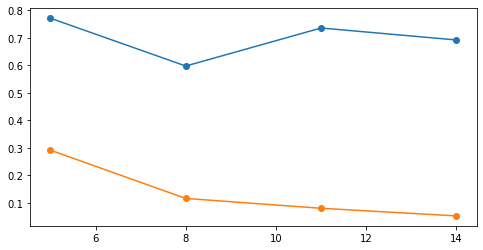

-81
[0.7520661157024794, 0.841897233201581, 0.7786561264822134, 0.8142292490118577]
[0.2567032061739579, 0.1182778896819595, 0.09016768213628092, 0.083211619145031]


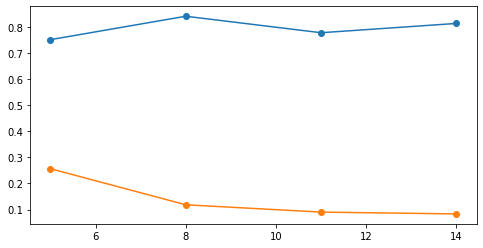

-78
[0.8972332015810277, 0.7905138339920948, 0.7628458498023716, 0.7391304347826086]
[0.236730676670004, 0.13858010807178048, 0.13479887910791877, 0.1979181463167245]


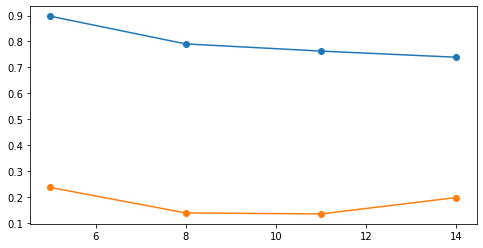

-75
[0.9090909090909091, 0.8972332015810277, 0.7075098814229249, 0.7312252964426877]
[0.40796416113351186, 0.22926217309329786, 0.23443721518733615, 0.2850560273183805]


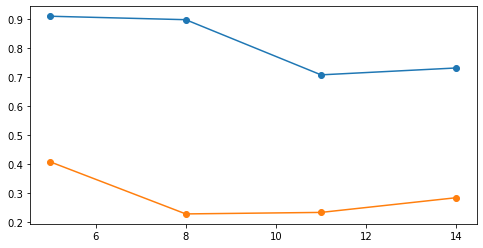

-72
[0.9960474308300395, 0.7193675889328063, 0.7470355731225297, 0.691699604743083]
[0.9055266195862488, 0.4203164036124303, 0.2827798248459796, 0.3567240267306932]


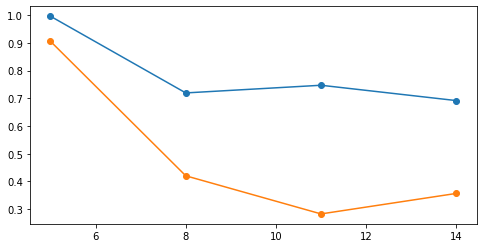

-69
[0.8932806324110671, 0.8774703557312253, 0.8221343873517787, 0.8893280632411067]
[0.4931399345905815, 0.4785746794342674, 0.40510282911926215, 0.3698652083660782]


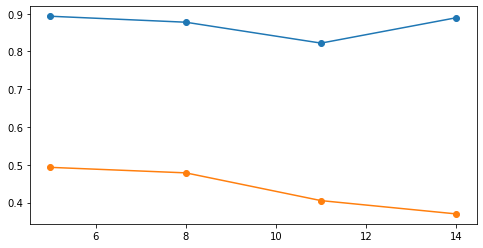

-66
[0.9367588932806324, 0.7430830039525692, 0.841897233201581, 0.7944664031620553]
[0.5407011074946009, 0.4201511584234422, 0.41901994328701, 0.1830116221776644]


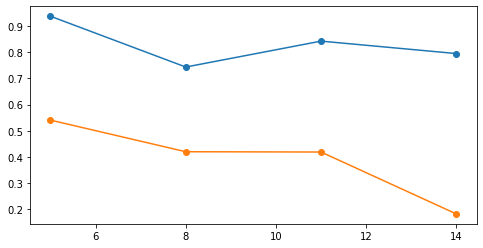

In [29]:
for i in range(len(tot_acc_list)):
    print(thres_list[i])
    print(tot_acc_list[i])
    print(tot_list_area[i])
    plt.figure(figsize = (8, 4))
    plt.plot(section_len_list,tot_acc_list[i])
    plt.plot(section_len_list,tot_list_area[i])
    plt.scatter(section_len_list, tot_acc_list[i])
    plt.scatter(section_len_list, tot_list_area[i])
    plt.show()

In [30]:
thres_list = [-84, -81, -78, -75, -72, -69, -66]
range_val = [3]#, 6, 7, 8, 9]
section_len_list = [5, 8, 11, 14]
area_thres1 = 0.0
area_thres2 = 1.0

test_slicer = 1

model = wifimodel('포스코센터')

In [31]:
tot_acc_list = []
tot_list_area = []

tot_area_dist = []
for thres in thres_list:
    acc_list = []
    list_area = []
    area_dist = []
    for section_len in section_len_list:
        model.create_refwifi_thres_section(thres, section_len)
        model.define_range(range_val[0])
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 50 회
성공 횟수 : 37회
현재 진행 상황 : 100 회
성공 횟수 : 85회
현재 진행 상황 : 150 회
성공 횟수 : 135회
현재 진행 상황 : 200 회
성공 횟수 : 185회
현재 진행 상황 : 250 회
성공 횟수 : 231회
test 횟수 : 253, 성공 횟수 : 231
91.30434782608695
0.4192209228115724
현재 진행 상황 : 50 회
성공 횟수 : 19회
현재 진행 상황 : 100 회
성공 횟수 : 69회
현재 진행 상황 : 150 회
성공 횟수 : 118회
현재 진행 상황 : 200 회
성공 횟수 : 154회
현재 진행 상황 : 250 회
성공 횟수 : 190회
test 횟수 : 253, 성공 횟수 : 190
75.09881422924902
0.1697424687638438
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 144회
현재 진행 상황 : 200 회
성공 횟수 : 188회
현재 진행 상황 : 250 회
성공 횟수 : 228회
test 횟수 : 253, 성공 횟수 : 228
90.11857707509881
0.1379553992103566
현재 진행 상황 : 50 회
성공 횟수 : 47회
현재 진행 상황 : 100 회
성공 횟수 : 93회
현재 진행 상황 : 150 회
성공 횟수 : 135회
현재 진행 상황 : 200 회
성공 횟수 : 178회
현재 진행 상황 : 250 회
성공 횟수 : 221회
test 횟수 : 253, 성공 횟수 : 221
87.35177865612648
0.07696871646238786
현재 진행 상황 : 50 회
성공 횟수 : 32회
현재 진행 상황 : 100 회
성공 횟수 : 82회
현재 진행 상황 : 150 회
성공 횟수 : 132회
현재 진행 상황 : 200 회
성공 횟수 : 171회
test 횟수 : 242, 성공 횟수 : 213
88.0165289

-84
[0.9130434782608695, 0.7509881422924901, 0.9011857707509882, 0.8735177865612648]
[0.4192209228115724, 0.1697424687638438, 0.1379553992103566, 0.07696871646238786]


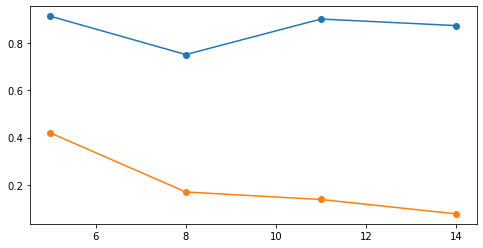

-81
[0.8801652892561983, 0.9446640316205533, 0.932806324110672, 0.9446640316205533]
[0.4350532294015029, 0.19030852612706034, 0.12050059558624067, 0.10833918990679971]


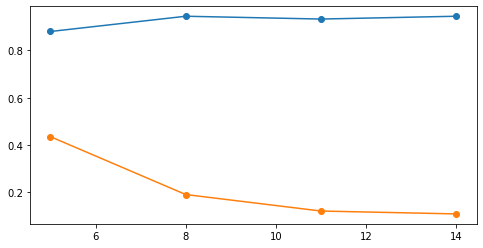

-78
[0.9209486166007905, 0.9288537549407114, 0.9090909090909091, 0.8774703557312253]
[0.43053993019932874, 0.18677194857048035, 0.18525193223492642, 0.21937379069628798]


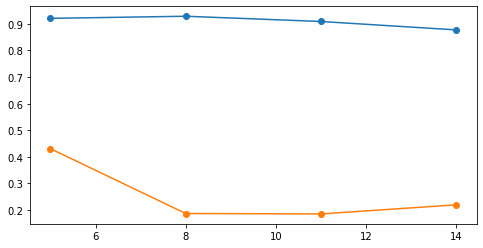

-75
[0.9486166007905138, 0.932806324110672, 0.8774703557312253, 0.9011857707509882]
[0.5540627184876455, 0.3000200350673389, 0.36926395087332065, 0.3194324676884317]


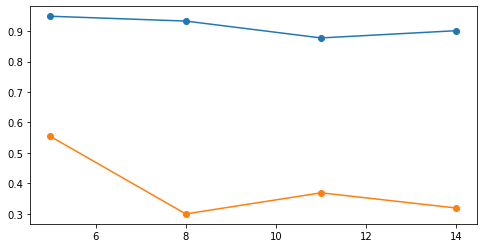

-72
[0.9960474308300395, 0.8853754940711462, 0.841897233201581, 0.8023715415019763]
[0.9231117054018083, 0.577474606073792, 0.4193075769406665, 0.39378248855470827]


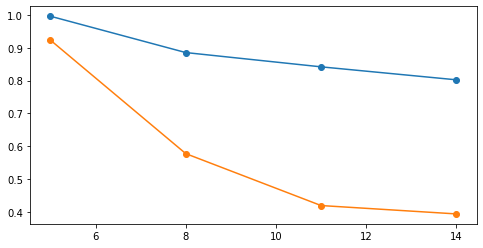

-69
[0.9525691699604744, 0.9209486166007905, 0.857707509881423, 0.9209486166007905]
[0.6418685730800349, 0.5400536230047775, 0.45597640582567295, 0.4371897354767307]


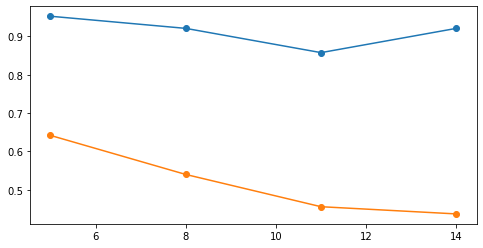

-66
[1.0, 0.8932806324110671, 0.9169960474308301, 0.857707509881423]
[0.9350845456745527, 0.532713654387576, 0.477293077190044, 0.216185121446693]


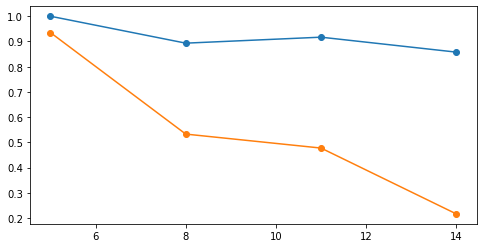

In [32]:
for i in range(len(tot_acc_list)):
    print(thres_list[i])
    print(tot_acc_list[i])
    print(tot_list_area[i])
    plt.figure(figsize = (8, 4))
    plt.plot(section_len_list,tot_acc_list[i])
    plt.plot(section_len_list,tot_list_area[i])
    plt.scatter(section_len_list, tot_acc_list[i])
    plt.scatter(section_len_list, tot_list_area[i])
    plt.show()

In [17]:
thres_list = [-64]
range_val = [4]
area_thres1 = 0.0
area_thres2 = 1.0

test_slicer = 1

model = wifimodel('포스코센터')

In [19]:
tot_acc_list = []
tot_list_area = []

tot_area_dist = []
for thres in thres_list:
    model.create_refwifi(thres)
    acc_list = []
    list_area = []
    area_dist = []
    for rang in range_val:
        model.define_range(rang)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
test 횟수 : 253, 성공 횟수 : 253
100.0
0.19492097635851344


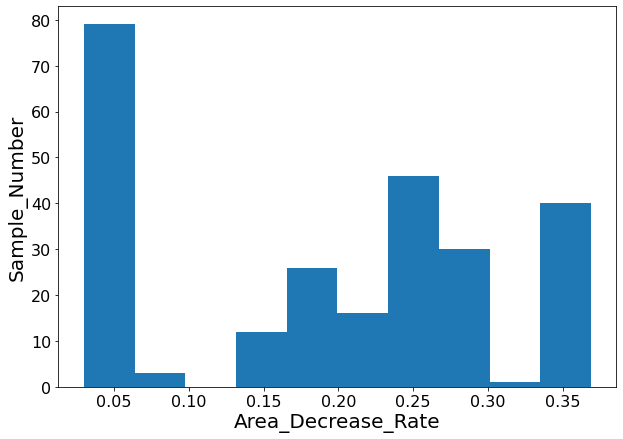

In [29]:
plt.figure(figsize = (10, 7))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rc('axes', labelsize=20)
plt.xlabel('Area_Decrease_Rate')
plt.ylabel('Sample_Number')
plt.hist(model.area_list)
plt.show()

In [30]:
thres_list = [-78]
range_val = [2]
area_thres1 = 0.0
area_thres2 = 1.0

test_slicer = 1

model = wifimodel('포스코실험동')

In [32]:
tot_acc_list = []
tot_list_area = []

tot_area_dist = []
for thres in thres_list:
    model.create_refwifi(thres)
    acc_list = []
    list_area = []
    area_dist = []
    for rang in range_val:
        model.define_range(rang)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
현재 진행 상황 : 300 회
성공 횟수 : 300회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 : 450 회
성공 횟수 : 450회
현재 진행 상황 : 500 회
성공 횟수 : 500회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 650 회
성공 횟수 : 650회
test 횟수 : 655, 성공 횟수 : 655
100.0
0.6742994899130115


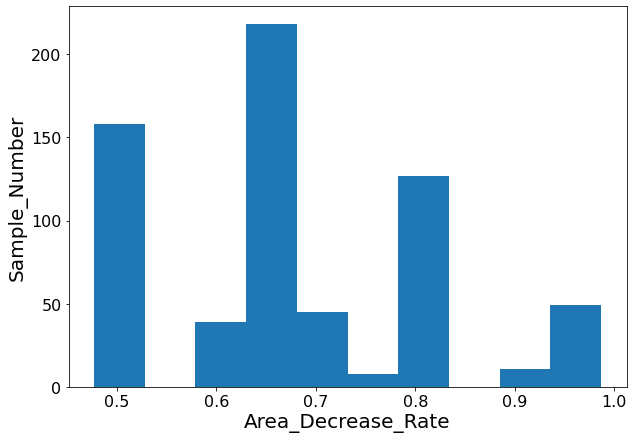

In [33]:
plt.figure(figsize = (10, 7))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rc('axes', labelsize=20)
plt.xlabel('Area_Decrease_Rate')
plt.ylabel('Sample_Number')
plt.hist(model.area_list)
plt.show()

In [5]:
thres_list = [-78]
range_val = [1]
area_thres1 = 0.0
area_thres2 = 1.0

test_slicer = 1

model = wifimodel('포스코실험동')

In [6]:
tot_acc_list = []
tot_list_area = []

tot_area_dist = []
for thres in thres_list:
    model.create_refwifi(thres)
    acc_list = []
    list_area = []
    area_dist = []
    for rang in range_val:
        model.define_range(rang)
        cord, acc, ara, fail = model.test_all(test_slicer)
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 50 회
성공 횟수 : 49회
현재 진행 상황 : 50 회
성공 횟수 : 49회
현재 진행 상황 : 50 회
성공 횟수 : 49회
현재 진행 상황 : 50 회
성공 횟수 : 49회
현재 진행 상황 : 100 회
성공 횟수 : 99회
현재 진행 상황 : 150 회
성공 횟수 : 149회
현재 진행 상황 : 150 회
성공 횟수 : 149회
현재 진행 상황 : 150 회
성공 횟수 : 149회
현재 진행 상황 : 150 회
성공 횟수 : 149회
현재 진행 상황 : 150 회
성공 횟수 : 149회
현재 진행 상황 : 150 회
성공 횟수 : 149회
현재 진행 상황 : 150 회
성공 횟수 : 149회
현재 진행 상황 : 150 회
성공 횟수 : 149회
현재 진행 상황 : 150 회
성공 횟수 : 149회
현재 진행 상황 : 150 회
성공 횟수 : 149회
현재 진행 상황 : 150 회
성공 횟수 : 149회
현재 진행 상황 : 150 회
성공 횟수 : 149회
현재 진행 상황 : 150 회
성공 횟수 : 149회
현재 진행 상황 : 150 회
성공 횟수 : 149회
현재 진행 상황 : 150 회
성공 횟수 : 149회
현재 진행 상황 : 200 회
성공 횟수 : 198회
현재 진행 상황 : 200 회
성공 횟수 : 198회
현재 진행 상황 : 200 회
성공 횟수 : 198회
현재 진행 상황 : 200 회
성공 횟수 : 198회
현재 진행 상황 : 200 회
성공 횟수 : 198회
현재 진행 상황 : 200 회
성공 횟수 : 198회
현재 진행 상황 : 200 회
성공 횟수 : 198회
현재 진행 상황 : 200 회
성공 횟수 : 198회
현재 진행 상황 : 200 회
성공 횟수 : 198회
현재 진행 상황 : 200 회
성공 횟수 : 198회
현재 진행 상황 : 200 회
성공 횟수 : 198회
현재 진행 상황 : 250 회
성공 횟수 : 246회
현재 진행 상황 : 300 회
성공 횟수 : 294회
현재 진행 상황 : 350 회
성공

In [9]:
thres_list = [-57, -60, -63, -66, -69, -72]
range_val = [1, 2, 4, 6]
range_val2 = [1, 1, 2, 2, 3]
area_thres1 = 0.0
area_thres2 = 1.0

test_slicer = 1

model = wifimodel('포스코실험동')

In [10]:
tot_acc_list = []
tot_list_area = []

tot_area_dist = []
for thres in thres_list:
    model.create_refwifi(thres)
    acc_list = []
    list_area = []
    area_dist = []
    for rang in range_val:
        model.define_range(rang)
        cord, acc, ara, fail = model.test_all(test_slicer)
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 249회
현재 진행 상황 : 300 회
성공 횟수 : 299회
현재 진행 상황 : 350 회
성

현재 진행 상황 : 450 회
성공 횟수 : 450회
현재 진행 상황 : 500 회
성공 횟수 : 500회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 650 회
성공 횟수 : 650회
test 횟수 : 655, 성공 횟수 : 655
100.0
0.9933713921302909
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 1

현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 : 450 회
성공 횟수 : 450회
현재 진행 상황 : 500 회
성공 횟수 : 500회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 650 회
성공 횟수 : 650회
test 횟수 : 655, 성공 횟수 : 655
100.0
0.9933713921302909
현재 진행 상황 : 50 회
성공 횟수 : 46회
현재 진행 상황 : 50 회
성공 횟수 : 46회
현재 진행 상황 : 50 회
성공 횟수 : 46회
현재 진행 상황 : 50 회
성공 횟수 : 46회
현재 진행 상황 : 100 회
성공 횟수 : 96회
현재 진행 상황 : 150 회
성공 횟수 : 146회
현재 진행 상황 : 150 회
성공 횟수 : 146회
현재 진행 상황 : 150 회
성공 횟수 : 146회
현재 진행 상황 : 150 회
성공 횟수 : 146회
현재 진행 상황 : 150 회
성공 횟수 : 146회
현재 진행 상황 : 150 회
성공 횟수 : 14

현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 : 450 회
성공 횟수 : 450회
현재 진행 상황 : 500 회
성공 횟수 : 500회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 :

현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
현재 진행 상황 : 300 회
성공 횟수 : 300회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 :

현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
현재 진행 상황 : 300 회
성공 횟수 : 300회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 :

현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 650 회
성공 횟수 : 650회
test 횟수 : 655, 성공 횟수 : 655
100.0
0.9693788189646402
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 200 회
성공 횟수 : 2

-57
[0.9969465648854962, 1.0, 1.0, 1.0]
[0.9281161712469511, 0.9875476575565807, 0.9933713921302909, 0.9933713921302909]


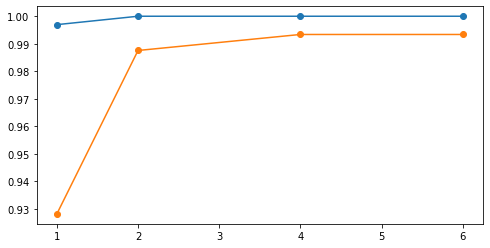

-60
[1.0, 1.0, 1.0, 1.0]
[0.8209868266184026, 0.9679633279224189, 0.9933713921302909, 0.9933713921302909]


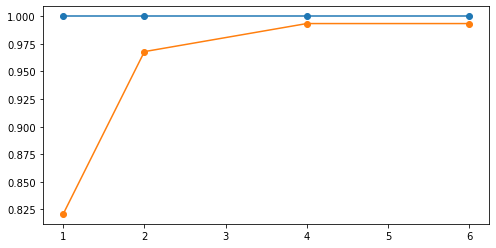

-63
[0.9923664122137404, 1.0, 1.0, 1.0]
[0.7135320484912405, 0.9185829118494995, 0.9931894004248624, 0.9933713921302909]


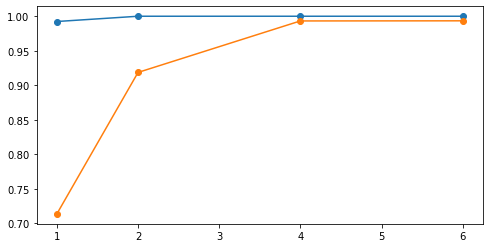

-66
[0.9786259541984733, 0.9847328244274809, 1.0, 1.0]
[0.7479668157973737, 0.8771957094227537, 0.9785592894384755, 0.9916525815790221]


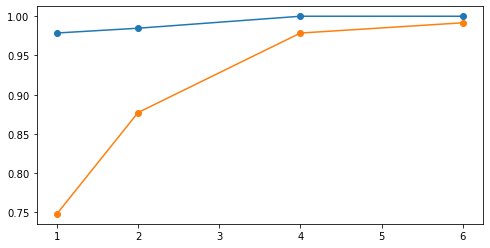

-69
[0.9801526717557252, 0.9877862595419847, 1.0, 1.0]
[0.7581758436994815, 0.8770839899047143, 0.9804095384436646, 0.9922187779959107]


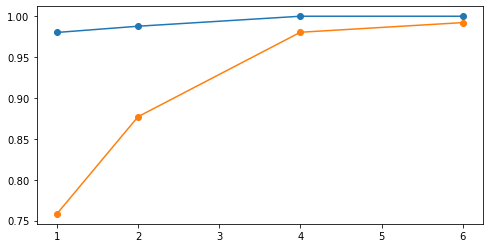

-72
[0.9618320610687023, 1.0, 1.0, 1.0]
[0.6143555305996056, 0.7554374585831956, 0.9693788189646402, 0.9918143519838475]


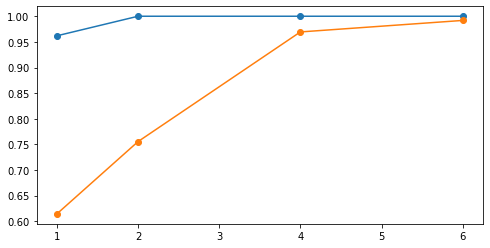

In [11]:
for i in range(len(tot_acc_list)):
    print(thres_list[i])
    print(tot_acc_list[i])
    print(tot_list_area[i])
    plt.figure(figsize = (8, 4))
    plt.plot(range_val,tot_acc_list[i])
    plt.plot(range_val,tot_list_area[i])
    plt.scatter(range_val, tot_acc_list[i])
    plt.scatter(range_val, tot_list_area[i])
    plt.show()